# Прогнозирование стоимости квартир на побережье Черного моря. 
# EDA - разведывательный анализ данных
Цель данного упражнения:
* Ознакомиться с данными, которые у нас есть
* Понять, какую информацию мы сможем из них взять
* Понять, какие данные влияют на целевую переменную, а какие нет
* Понять, какие данные необходимо собирать из внешних источников
* Сформировать желаемый вид датасета, к которому будем стремиться преобразовать собранные данные

# Загрузка библиотек

In [1]:
#!pip install lightgbm

In [2]:
# Загрузка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from itertools import chain
from scipy.stats import ttest_ind

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from lightgbm import LGBMClassifier

%matplotlib inline

# Первичный осмотр данных
Посмотрим на выгруженные данные.

In [3]:
df = pd.read_csv('cian.csv')

In [4]:
display(df.head())
df.info()

,balconiesCount,category,flatType,floorNumber,fromDeveloper,fullUrl,isApartments,isAuction,kitchenArea,livingArea,...,price,mortgageAllowed,region,city,floorsCount,buildYear,isComplete,passengerLiftsCount,cargoLiftsCount,materialType
0,NaN,newBuildingFlatSale,rooms,5.0,True,https://krym.cian.ru/sale/flat/239743201/,True,True,NaN,NaN,...,18288000,True,Крым,Ялта,10,NaN,True,1.0,0.0,monolith
1,NaN,flatSale,rooms,2.0,False,https://krym.cian.ru/sale/flat/246745649/,NaN,True,NaN,26.0,...,3984750,NaN,Крым,Ялта,6,2015.0,True,1.0,NaN,monolithBrick
2,NaN,newBuildingFlatSale,rooms,15.0,True,https://krym.cian.ru/sale/flat/246656839/,True,True,NaN,NaN,...,14580000,True,Крым,Ялта,18,NaN,True,1.0,0.0,monolith
3,NaN,newBuildingFlatSale,rooms,7.0,True,https://krym.cian.ru/sale/flat/245655396/,False,True,NaN,NaN,...,5200000,True,Крым,Ялта,8,NaN,True,1.0,0.0,monolith
4,1.0,newBuildingFlatSale,rooms,6.0,True,https://krym.cian.ru/sale/flat/239743211/,True,True,NaN,NaN,...,21024000,True,Крым,Ялта,10,NaN,True,1.0,0.0,monolith


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36713 entries, 0 to 36712
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   balconiesCount       20047 non-null  float64
 1   category             36713 non-null  object 
 2   flatType             36713 non-null  object 
 3   floorNumber          36712 non-null  float64
 4   fromDeveloper        36713 non-null  bool   
 5   fullUrl              36713 non-null  object 
 6   isApartments         20812 non-null  object 
 7   isAuction            36713 non-null  bool   
 8   kitchenArea          20475 non-null  float64
 9   livingArea           20853 non-null  float64
 10  loggiasCount         17423 non-null  float64
 11  roomsCount           33941 non-null  float64
 12  totalArea            36713 non-null  float64
 13  price                36713 non-null  int64  
 14  mortgageAllowed      25508 non-null  object 
 15  region               36713 non-null 

Нам удалось выгрузить с cian 23 признака (включая fullUrl), некоторые содержат пропуски.

# Вспомогательные функции

Напишем функции, которае помогут нам при анализе переменных

In [5]:
# функция для визуализации распределения числовых признаков

def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

In [6]:
# функции для анализа признаков
# для числовых признаков
def num_info(column):
    print('Количество пропусков: {},'.format(column.isnull().sum()))
    print('{},'.format(column.describe()))
    visualize_distributions({column.name: column})

# для категориальных признаков
def cat_info(column):
    print('Количество пропусков: {},'.format(column.isnull().sum()))
    print('{},'.format(column.describe()))
    print('Распределение:\n{},'.format(column.value_counts())) 

In [7]:
# функция для оценки распределения категориальных признаков в зависимости от целевой переменной
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, y='price', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [8]:
# функция для определения границ выбросов
def get_iqr_col(column):
    # Находим необходимые параметры
    median = column.median()
    quartile_1, quartile_3 = np.percentile(column, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('Медиана: {},'.format(median),'25-й перцентиль: {},'.format(quartile_1), '75-й перцентиль: {},'.format(quartile_3)
      , "IQR: {}, ".format(iqr),"Границы выбросов: [{}, {}].".format(lower_bound,upper_bound))

# Первичный осмотр данных в столбцах

## balconiesCount
Количество балконов

Скорее всего пропуски означают отсутствие балкона. Заменим их на значение 0

In [9]:
df.balconiesCount = df.balconiesCount.fillna(0)

Применим функцию num_info() для анализа признака:

Количество пропусков: 0,
count    36713.000000
mean         0.486858
std          0.630884
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          4.000000
Name: balconiesCount, dtype: float64,


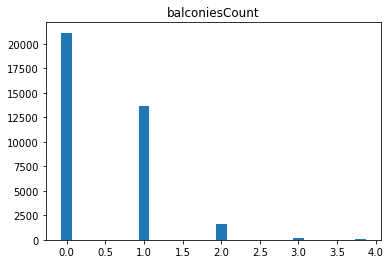

In [10]:
num_info(df.balconiesCount)

Возможно, стоит сделать признак бинарным (есть балкон или нет), но пока что оставим как есть.

Преобразуем значения в формат int32

In [11]:
df['balconiesCount']=df['balconiesCount'].astype('int32')

## loggiasCount
Количество лоджий

In [12]:
# Аналогично балконам, заменим пропуски на нули.
df.loggiasCount = df.loggiasCount.fillna(0)

Количество пропусков: 0,
count    36713.000000
mean         0.320677
std          0.573429
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          4.000000
Name: loggiasCount, dtype: float64,


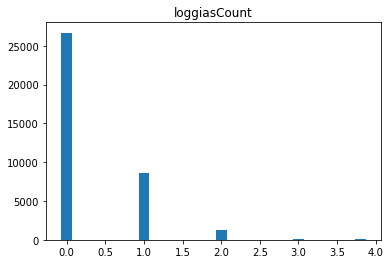

In [13]:
num_info(df.loggiasCount)

Преобразуем значения в формат int32

In [14]:
df['loggiasCount']=df['loggiasCount'].astype('int32')

## category
Категория объявления - новая квартира или вторичное жилье

In [15]:
cat_info(df.category)

Количество пропусков: 0,
count        36713
unique           2
top       flatSale
freq         31832
Name: category, dtype: object,
Распределение:
flatSale               31832
newBuildingFlatSale     4881
Name: category, dtype: int64,


Пропусков нет. Сделаем признак бинарным и переименуем колонку в newBuilding.

In [16]:
dic_category = {
    'newBuildingFlatSale': 1,
    'flatSale': 0,
}
df['category'] = df['category'].map(dic_category)
df.rename(columns = {'category':'newBuilding'}, inplace = True) 

## flatType
Тип квартиры (комнаты, студия, свободная планировка)

In [17]:
cat_info(df.flatType)

Количество пропусков: 0,
count     36713
unique        3
top       rooms
freq      33941
Name: flatType, dtype: object,
Распределение:
rooms       33941
studio       2217
openPlan      555
Name: flatType, dtype: int64,


## floorsCount
Количество этажей в здании

Количество пропусков: 0,
count    36713.000000
mean         8.968921
std          5.642592
min          1.000000
25%          5.000000
50%          8.000000
75%         12.000000
max         45.000000
Name: floorsCount, dtype: float64,


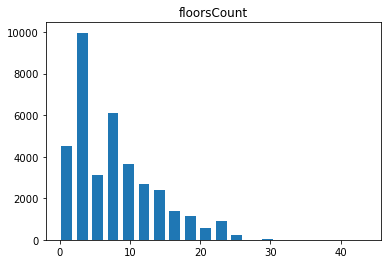

In [18]:
num_info(df.floorsCount)

## floorNumber
Этаж

Всего один пропуск в восьмиэтажном здании. Удалим пропуск.

In [19]:
df = df[df['floorNumber'].isna() == False]

Количество пропусков: 0,
count    36712.000000
mean         5.076542
std          4.114382
min         -2.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         27.000000
Name: floorNumber, dtype: float64,


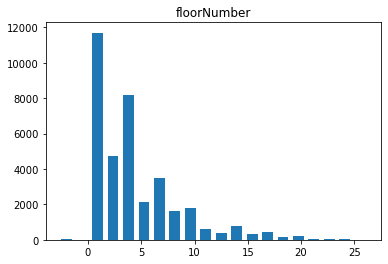

In [20]:
num_info(df.floorNumber)

Всего один пропуск в восьмиэтажном здании. Удалим пропуск.

In [21]:
df = df[df['floorNumber'].isna() == False]

На основании признаков floorNumber и floorsCount можем сгенерировать новые признаки:
* isBasement - в случае, если этаж ниже первого
* isFristFloor - первый этаж
* isLastFloor - последний этаж

Преобразуем значения в формат int32

In [22]:
df['floorNumber']=df['floorNumber'].astype('int32')

## fromDeveloper
От застройщика?

In [23]:
cat_info(df.fromDeveloper)

Количество пропусков: 0,
count     36712
unique        2
top       False
freq      34243
Name: fromDeveloper, dtype: object,
Распределение:
False    34243
True      2469
Name: fromDeveloper, dtype: int64,


Заменим значения на 1 и 0

## isApartments
Является ли квартира апартаментами

In [24]:
cat_info(df.isApartments)

Количество пропусков: 15900,
count     20812
unique        2
top       False
freq      18156
Name: isApartments, dtype: object,
Распределение:
False    18156
True      2656
Name: isApartments, dtype: int64,


Заменим пропуски на False. Раз значение не указано, скорее всего квартира апартаментами не является.

In [25]:
df.isApartments = df.isApartments.fillna(False)

## isAuction
Является ли продажа аукционом?

In [26]:
cat_info(df.isAuction)

Количество пропусков: 0,
count     36712
unique        2
top       False
freq      32120
Name: isAuction, dtype: object,
Распределение:
False    32120
True      4592
Name: isAuction, dtype: int64,


## totalArea
Общая площадь

Количество пропусков: 0,
count    36712.000000
mean        66.666093
std         54.053832
min         10.000000
25%         41.800000
50%         57.000000
75%         76.500000
max       5471.000000
Name: totalArea, dtype: float64,


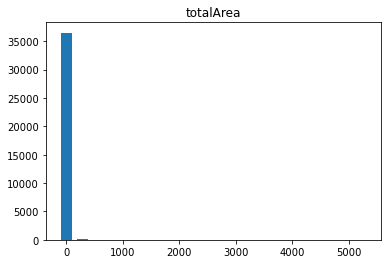

In [27]:
num_info(df.totalArea)

Отбросим выбросы

In [28]:
# закомментируем т.к. долго считает
get_iqr_col(df.totalArea)

Медиана: 57.0, 25-й перцентиль: 41.8, 75-й перцентиль: 76.5, IQR: 34.7,  Границы выбросов: [-10.250000000000007, 128.55].


Квартиры с площадью более более 129.25 м^2 являются выбросами. Отбросим эти квартиры.

In [29]:
df = df[df.totalArea <= 129.25]

## livingArea
Жилая площадь

Видим большое количество пропусков. Заменим пропуски на средний процент от общей площади.b

In [30]:
meanLivAreaRatio = df[df.livingArea.isna()==False].livingArea.mean() / df[df.livingArea.isna()==False].totalArea.mean()
df.livingArea = df.livingArea.fillna(df.totalArea * meanLivAreaRatio)

Количество пропусков: 0,
count    34497.000000
mean        33.640182
std         15.167848
min          1.000000
25%         21.200000
50%         31.071071
75%         42.000000
max        126.700000
Name: livingArea, dtype: float64,


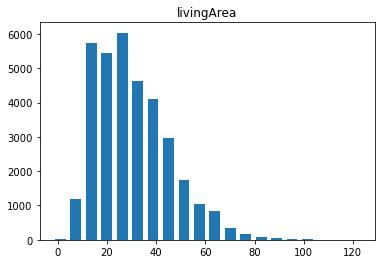

In [31]:
num_info(df.livingArea)

## kitchenArea
Площадь кухни

Ананлогично жилой площади, заменим пропуски на средную площадь в зависимости от раздела общей площади

In [32]:
meanKitchenAreaRatio = df[df.kitchenArea.isna()==False].kitchenArea.mean() / df[df.kitchenArea.isna()==False].totalArea.mean()
df.kitchenArea = df.kitchenArea.fillna(df.totalArea * meanKitchenAreaRatio)

Количество пропусков: 0,
count    34497.000000
mean        11.191265
std          5.481616
min          1.000000
25%          7.300000
50%         10.000000
75%         13.782113
max         70.900000
Name: kitchenArea, dtype: float64,


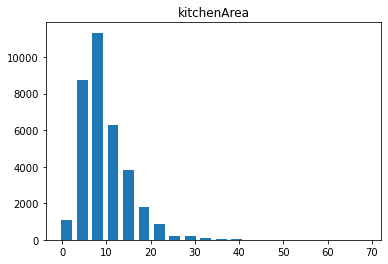

In [33]:
num_info(df.kitchenArea)

## roomsCount
Количество комнат

Заменим пропуски на среднее значение в зависимости от общей площади

In [34]:
meanRoomsCountRatio = df[df.roomsCount.isna()==False].roomsCount.mean() / df[df.roomsCount.isna()==False].totalArea.mean()
df.roomsCount = df.roomsCount.fillna(round(df.totalArea * meanRoomsCountRatio))

Количество пропусков: 0,
count    34497.000000
mean         1.977911
std          0.877087
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: roomsCount, dtype: float64,


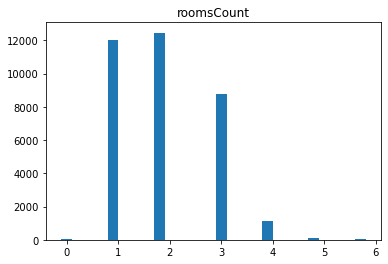

In [35]:
num_info(df.roomsCount)

Заменим количество комнат в квартирах с 0 комнатами на 1

In [36]:
dic_roomsCount = {
    0: 1,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
}
df['roomsCount'] = df['roomsCount'].map(dic_roomsCount)

Количество пропусков: 0,
count    34497.000000
mean         1.978810
std          0.875571
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: roomsCount, dtype: float64,


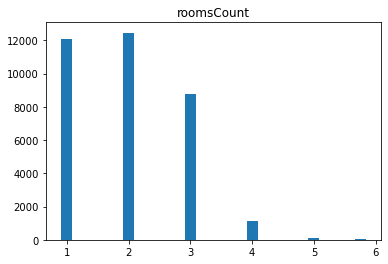

In [37]:
num_info(df.roomsCount)

## price
Стоимость квартиры, целевая переменная

Количество пропусков: 0,
count    3.449700e+04
mean     6.764576e+06
std      2.605841e+07
min      5.300000e+05
25%      3.550000e+06
50%      4.950000e+06
75%      7.200000e+06
max      3.850000e+09
Name: price, dtype: float64,


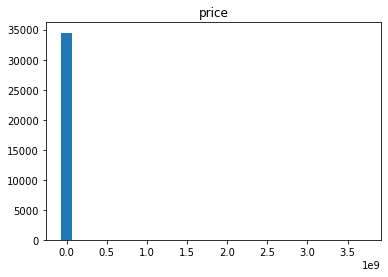

In [38]:
num_info(df.price)

Определим границы выбросов

In [39]:
get_iqr_col(df.price)

Медиана: 4950000.0, 25-й перцентиль: 3550000.0, 75-й перцентиль: 7200000.0, IQR: 3650000.0,  Границы выбросов: [-1925000.0, 12675000.0].


Медиана: 4950000.0, 25-й перцентиль: 3550000.0, 75-й перцентиль: 7200000.0, IQR: 3650000.0,  Границы выбросов: [-1925000.0, 12675000.0].

In [40]:
df = df[df['price'] <= 12675000]

## mortgageAllowed
Возможность взять в ипотеку

In [41]:
cat_info(df.mortgageAllowed)

Количество пропусков: 10068,
count     21462
unique        2
top        True
freq      16986
Name: mortgageAllowed, dtype: object,
Распределение:
True     16986
False     4476
Name: mortgageAllowed, dtype: int64,


Много пропусков и не понятно что с ними делать. Удалим признак

In [42]:
df = df.drop(['mortgageAllowed'], axis=1)

## region
Регион

In [43]:
cat_info(df.region)

Количество пропусков: 0,
count             31530
unique                3
top       Краснодарский
freq              16504
Name: region, dtype: object,
Распределение:
Краснодарский    16504
Крым             10993
Севастополь       4033
Name: region, dtype: int64,


Пропусков нет. Заменим значения на английские названия

In [44]:
dic_region = {
    'Крым': 'crimea',
    'Краснодарский': 'krasnodar',
    'Севастополь': 'sevastopol'
}
df['region'] = df['region'].map(dic_region)

## city
Город

In [45]:
cat_info(df.city)

Количество пропусков: 0,
count            31530
unique              24
top       Новороссийск
freq              4533
Name: city, dtype: object,
Распределение:
Новороссийск                4533
Анапа                       4476
Сочи                        4179
Симферополь                 3623
Геленджик                   2763
Ялта                        2739
Гагаринский                 2059
Ленинский                   1039
Евпатория                    988
Феодосия                     917
Алушта                       832
Керчь                        768
Нахимовский                  660
Симферопольский              419
Туапсе                       369
Саки                         318
Балаклавский                 302
Сакский                      191
Туапсинский                  182
Судак                        154
Кировский                      9
Бахчисарайский                 7
Крымский                       2
Севастопольская зона ЮБК       1
Name: city, dtype: int64,


<AxesSubplot:>

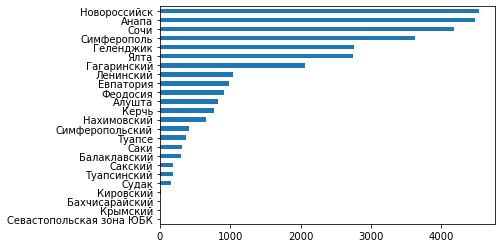

In [46]:
df['city'].value_counts(ascending=True).plot(kind='barh')

Пропусков нет. Заменим значения на английские названия, отбросим города с количеством квартир < 150

In [47]:
dic_city = {
    'Новороссийск': 'novorossiysk',
    'Анапа': 'anapa',
    'Сочи': 'sochi',
    'Симферополь': 'simferopol',
    'Геленджик': 'gelendzhik',
    'Ялта': 'yalta',
    'Гагаринский': 'gagarinskiy',
    'Ленинский': 'leninskiy',
    'Евпатория': 'evpatoriya',
    'Феодосия': 'feodosiya',
    'Алушта': 'alushta',
    'Керчь': 'kerch',
    'Нахимовский': 'nakhimovskiy',
    'Симферопольский': 'simferopolskiy',
    'Туапсе': 'tuapse',
    'Саки': 'saki',
    'Балаклавский': 'balaklavskiy',
    'Сакский': 'sakskiy',
    'Туапсинский': 'tuapsinskiy',
    'Судак': 'sudak',
}
df['city'] = df['city'].map(dic_city)

In [48]:
df = df[df['city'].isna() == False]

In [49]:
cat_info(df.city)

Количество пропусков: 0,
count            31511
unique              20
top       novorossiysk
freq              4533
Name: city, dtype: object,
Распределение:
novorossiysk      4533
anapa             4476
sochi             4179
simferopol        3623
gelendzhik        2763
yalta             2739
gagarinskiy       2059
leninskiy         1039
evpatoriya         988
feodosiya          917
alushta            832
kerch              768
nakhimovskiy       660
simferopolskiy     419
tuapse             369
saki               318
balaklavskiy       302
sakskiy            191
tuapsinskiy        182
sudak              154
Name: city, dtype: int64,


## buildYear
Год постройки

In [50]:
df.buildYear.isnull().sum()

16522

Больше половины пропусков. Удалим признак.

In [51]:
df = df.drop(['buildYear'], axis=1)

## isComplete
Статус завершения строительства

In [52]:
cat_info(df.isComplete)

Количество пропусков: 1552,
count     29959
unique        2
top        True
freq      28686
Name: isComplete, dtype: object,
Распределение:
True     28686
False     1273
Name: isComplete, dtype: int64,


Скорее всего пропуски означают, что дом уже построен. Заменим пустые значения на true.

In [53]:
df.isComplete = df.isComplete.fillna(True)

## passengerLiftsCount
Количество пассажирских лифтов

Обработаем пропуски. Посмотрим на количество этажей в домах с пропусками.

In [54]:
df[df.passengerLiftsCount.isna() == True].floorsCount.value_counts()

5     5019
3     1434
4     1420
2     1089
9      963
6      635
10     598
1      426
7      417
8      322
16     212
12     188
11     154
20      97
13      91
14      87
17      85
18      70
15      64
19      38
21      30
25      25
23      18
24      13
22       9
26       4
27       1
30       1
Name: floorsCount, dtype: int64

В домах с количеством этажей < 6 чаще всего нет лифтов

In [55]:
df[df['floorsCount'] <= 5].passengerLiftsCount.value_counts()

0.0    3510
1.0     527
2.0      18
4.0       3
3.0       2
Name: passengerLiftsCount, dtype: int64

В домах с количеством этажей > 5 чаще всего 1 пассажирский лифт

In [56]:
df[df['floorsCount'] > 5].passengerLiftsCount.value_counts()

 1.0    10832
 0.0     1782
 2.0     1120
 3.0      122
 4.0       83
-1.0        2
Name: passengerLiftsCount, dtype: int64

Заменим пропуски

In [57]:
df.loc[df.passengerLiftsCount==-1, 'passengerLiftsCount'] = 1

In [58]:
df.loc[df['floorsCount'] <= 5, 'passengerLiftsCount'] = df[df['floorsCount'] <= 5].passengerLiftsCount.fillna(0)
df.loc[df['floorsCount'] > 5, 'passengerLiftsCount'] = df[df['floorsCount'] > 5].passengerLiftsCount.fillna(1)

Заменим значение -1 на 1

In [59]:
df.loc[df.passengerLiftsCount==-1, 'passengerLiftsCount'] = 1

Количество пропусков: 0,
count    31511.000000
mean         0.586303
std          0.609224
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: passengerLiftsCount, dtype: float64,


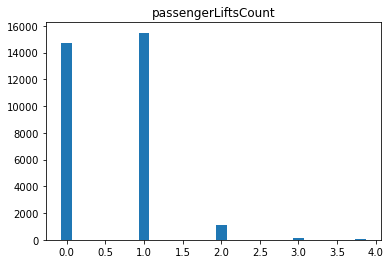

In [60]:
num_info(df.passengerLiftsCount)

In [61]:
#Преобразуем значения в формат int32
df['passengerLiftsCount']=df['passengerLiftsCount'].astype('int32')

Сделаем признак бинарным категориальным

In [62]:
df['passengerLiftsCount'] = df['passengerLiftsCount'].apply(lambda x: 0 if x == 0 else 1)

## cargoLiftsCount
Количество грузовых лифтов

Заменим пропуски на 0

In [63]:
df.cargoLiftsCount = df.cargoLiftsCount.fillna(0)

Количество пропусков: 0,
count    31511.000000
mean         0.163149
std          0.397958
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: cargoLiftsCount, dtype: float64,


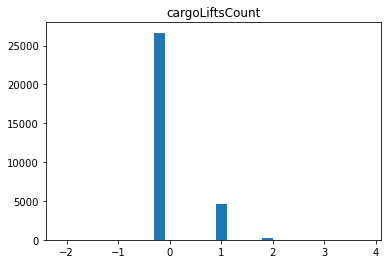

In [64]:
num_info(df.cargoLiftsCount)

Заменим значение -2 на 2

In [65]:
df.loc[df.cargoLiftsCount==-2, 'cargoLiftsCount'] = 2

In [66]:
#Преобразуем значения в формат int32
df['cargoLiftsCount']=df['cargoLiftsCount'].astype('int32')

Сделаем признак бинарным категориальным

In [67]:
df['cargoLiftsCount'] = df['cargoLiftsCount'].apply(lambda x: 0 if x == 0 else 1)

## materialType
Материал дома

In [68]:
cat_info(df.materialType)

Количество пропусков: 10098,
count        21413
unique          12
top       monolith
freq          9847
Name: materialType, dtype: object,
Распределение:
monolith             9847
block                4368
panel                3363
brick                2574
monolithBrick        1075
stalin                102
old                    44
wood                   24
aerocreteBlock          7
foamConcreteBlock       5
wireframe               3
gasSilicateBlock        1
Name: materialType, dtype: int64,


Заменим пропуски на значение unknown

In [69]:
df.materialType = df.materialType.fillna('unknown')

## Итоги первичного осмотра данных

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31511 entries, 1 to 36712
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   balconiesCount       31511 non-null  int32  
 1   newBuilding          31511 non-null  int64  
 2   flatType             31511 non-null  object 
 3   floorNumber          31511 non-null  int32  
 4   fromDeveloper        31511 non-null  bool   
 5   fullUrl              31511 non-null  object 
 6   isApartments         31511 non-null  bool   
 7   isAuction            31511 non-null  bool   
 8   kitchenArea          31511 non-null  float64
 9   livingArea           31511 non-null  float64
 10  loggiasCount         31511 non-null  int32  
 11  roomsCount           31511 non-null  int64  
 12  totalArea            31511 non-null  float64
 13  price                31511 non-null  int64  
 14  region               31511 non-null  object 
 15  city                 31511 non-null 

В результате данного шага мы оставили 20 признаков и избавились от пропусков.

# Генерация признаков

## hasBalcony
сгенерируем новый признак, значения которого будут равняться сумме количества лоджий и балконов т.к. для жильцов большой разницы нет (как мне кажется).

In [71]:
df['hasBalcony'] = df.loggiasCount + df.balconiesCount

In [72]:
cat_info(df.hasBalcony)

Количество пропусков: 0,
count    31511.000000
mean         0.778204
std          0.731676
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: hasBalcony, dtype: float64,
Распределение:
1    15236
0    11935
2     3856
3      385
4       88
6        6
5        3
8        2
Name: hasBalcony, dtype: int64,


Сделаем признак бинарным категориальным и удалим отдельные признаки по количеству балконов или лоджий.

In [73]:
df['hasBalcony'] = df['hasBalcony'].apply(lambda x: 0 if x == 0 else 1)

In [74]:
df = df.drop(['loggiasCount'], axis=1)
df = df.drop(['balconiesCount'], axis=1)

## isBasement
Находится ли квартира в подвале

In [75]:
df['isBasement'] = df['floorNumber'].apply(lambda x: 1 if x < 0 else 0)

In [76]:
df.isBasement.value_counts()

0    31473
1       38
Name: isBasement, dtype: int64

## isFirstFloor
Находится ли квартира на первом этаже

In [77]:
df['isFirstFloor'] = df['floorNumber'].apply(lambda x: 1 if x == 1 else 0)

In [78]:
df.isFirstFloor.value_counts()

0    25776
1     5735
Name: isFirstFloor, dtype: int64

Заменим отрицательные значения в признаке floorNumber т.к. возникнут проблемы при логорифмировании

In [79]:
df['floorNumber'] = df['floorNumber'].apply(lambda x: 1 if x < 0 else x)

## isLastFloor
Находится ли квартира на последнем этаже

In [80]:
# Создадим для начала вспомогательный признак - номер этажа, если считать сверху вниз.
df['backwardFloorNumber']=df['floorsCount']-df['floorNumber']

In [81]:
df['isLastFloor'] = df['backwardFloorNumber'].apply(lambda x: 1 if x == 0 else 0)

In [82]:
df.isLastFloor.value_counts()

0    25083
1     6428
Name: isLastFloor, dtype: int64

In [83]:
df = df.drop(['backwardFloorNumber'], axis=1)

## cityPopulation
Население города

Добавим данные о населении города, взяв информацию из Википедии.

In [84]:
dic_cityPopulation = {
    'novorossiysk': 274956,
    'anapa': 88879,
    'sochi': 443562,
    'simferopol': 342054,
    'gelendzhik': 76783,
    'yalta': 79056,
    'gagarinskiy': 159017,
    'leninskiy': 58441,
    'evpatoriya': 108248,
    'feodosiya': 68001,
    'alushta': 30088,
    'kerch': 151548,
    'nakhimovskiy': 119507,
    'simferopolskiy': 161997,
    'tuapse': 61180,
    'saki': 24654,
    'balaklavskiy': 51092,
    'sakskiy': 76426,
    'tuapsinskiy': 127717,
    'sudak': 16489,
}
df['cityPopulation'] = df['city'].map(dic_cityPopulation)

## cityArea
Площадь города

Добавим данные о площади города, взяв информацию из Википедии.

In [85]:
dic_cityArea = {
    'novorossiysk': 83.5,
    'anapa': 59,
    'sochi': 176.8,
    'simferopol': 107.4,
    'gelendzhik': 19.25,
    'yalta': 18.2,
    'gagarinskiy': 61.1,
    'leninskiy': 2918.6,
    'evpatoriya': 65,
    'feodosiya': 40,
    'alushta': 7,
    'kerch': 108,
    'nakhimovskiy': 267.7,
    'simferopolskiy': 1752.5,
    'tuapse': 33.4,
    'saki': 28.7,
    'balaklavskiy': 530.3,
    'sakskiy': 2257.5,
    'tuapsinskiy': 2399.2,
    'sudak': 23.5,
}
df['cityArea'] = df['city'].map(dic_cityArea)

## populationDensity
Плотность населения

In [86]:
df['populationDensity'] = df.cityPopulation / df.cityArea

## areaPerRoom
Отношение общей площади к количеству комнат

In [87]:
df['areaPerRoom'] = df.totalArea / df.roomsCount

In [88]:
# сохраним датасет
df.to_csv('cian_eda.csv', index=False)
# удалим признак fullUrl т.к. он нам не понадобится на следующих этапах
df = df.drop(['fullUrl'], axis=1)

# Промежуточные итоги

In [89]:
df.head()

,newBuilding,flatType,floorNumber,fromDeveloper,isApartments,isAuction,kitchenArea,livingArea,roomsCount,totalArea,...,cargoLiftsCount,materialType,hasBalcony,isBasement,isFirstFloor,isLastFloor,cityPopulation,cityArea,populationDensity,areaPerRoom
1,0,rooms,2,False,False,True,10.413152,26.000000,1,54.40,...,0,monolithBrick,1,0,0,0,79056,18.2,4343.736264,54.40
3,1,rooms,7,True,False,True,8.093163,24.327497,1,42.28,...,0,monolith,0,0,0,0,79056,18.2,4343.736264,42.28
6,1,rooms,6,True,True,True,10.126025,30.438141,1,52.90,...,0,monolith,0,0,0,0,79056,18.2,4343.736264,52.90
8,0,rooms,2,False,True,True,10.000000,13.809365,1,24.00,...,0,monolith,1,0,0,0,79056,18.2,4343.736264,24.00
9,0,rooms,3,False,False,True,8.613821,25.892559,1,45.00,...,1,monolith,1,0,0,0,79056,18.2,4343.736264,45.00


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31511 entries, 1 to 36712
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   newBuilding          31511 non-null  int64  
 1   flatType             31511 non-null  object 
 2   floorNumber          31511 non-null  int64  
 3   fromDeveloper        31511 non-null  bool   
 4   isApartments         31511 non-null  bool   
 5   isAuction            31511 non-null  bool   
 6   kitchenArea          31511 non-null  float64
 7   livingArea           31511 non-null  float64
 8   roomsCount           31511 non-null  int64  
 9   totalArea            31511 non-null  float64
 10  price                31511 non-null  int64  
 11  region               31511 non-null  object 
 12  city                 31511 non-null  object 
 13  floorsCount          31511 non-null  int64  
 14  isComplete           31511 non-null  bool   
 15  passengerLiftsCount  31511 non-null 

Мы сгенерировали 8 новых признаков, некоторые удалили. Теперь их общее количество - 26.

   * Числовые - 11: floorNumber, kitchenArea, livingArea, roomsCount, totalArea, floorsCount, cityPopulation, cityArea, populationDensity, areaPerRoom и целевая переменная price
   * Категориальные оценочные - 4 шт.: flatType, region, city, materialType
   * Категориальные бинарные - 11 шт.: newBuilding, fromDeveloper, isApartments, isAuction, isComplete, hasBalcony, isBasement, isFirstFloor, isLastFloor, passengerLiftsCount, cargoLiftsCount

In [91]:
# Составим список бинарных категориальных признаков:
bin_features = [
    'newBuilding',
    'fromDeveloper',
    'isApartments',
    'isAuction',
    'isComplete',
    'hasBalcony',
    'isBasement',
    'isFirstFloor',
    'isLastFloor',
    'passengerLiftsCount',
    'cargoLiftsCount',
]

# Составим список категориальных признаков:
cat_features = [
    'flatType',
    'region',
    'city',
    'materialType',
]
 
# Составим список числовых признаков:
num_features = [
    'price',
    'floorNumber',
    'kitchenArea',
    'livingArea',
    'roomsCount',
    'totalArea',
    'floorsCount',
    'cityPopulation',
    'cityArea',
    'populationDensity',
    'areaPerRoom',
]

# Анализ полученных признаков

## Корреляционный анализ
Выясним, какие столбцы коррелируют со стоймостью квартиры.
Корреляцию рассмотрим только для числовых столбцов.

<AxesSubplot:>

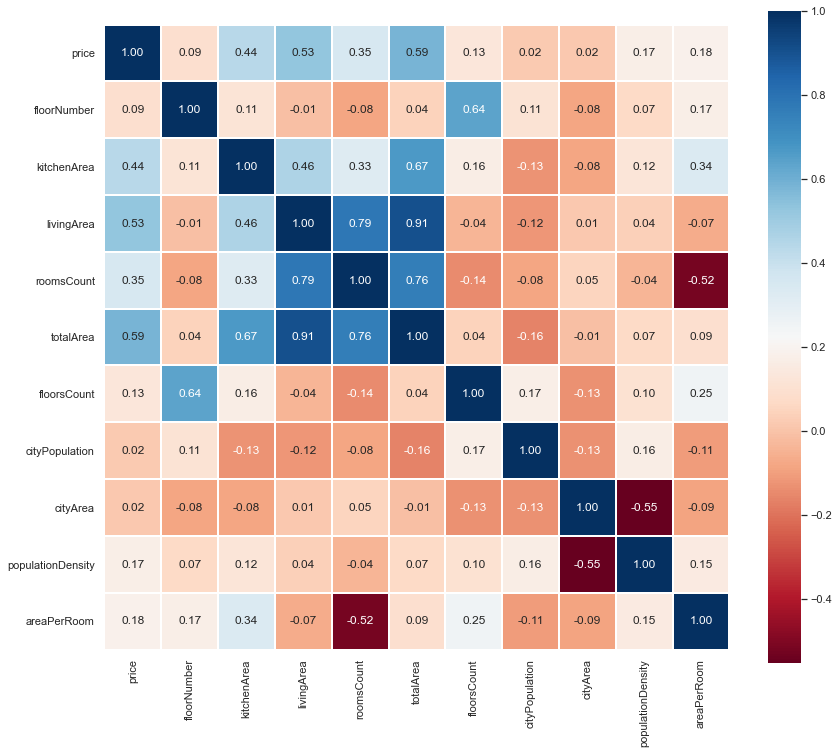

In [92]:
# Проверяем на мультиколлинеарность и кореляцию числовых признаков между собой и с главным признаком "price":
sns.set(font_scale=1)
plt.subplots(figsize=(14, 12))
sns.heatmap(df[num_features].corr(), square=True, annot=True,
            fmt=".2f", linewidths=1, cmap="RdBu")

Сильно скоррелированы между собой признаки totalArea и livingArea.

Посмотрим, как выглядят распределения числовых признаков

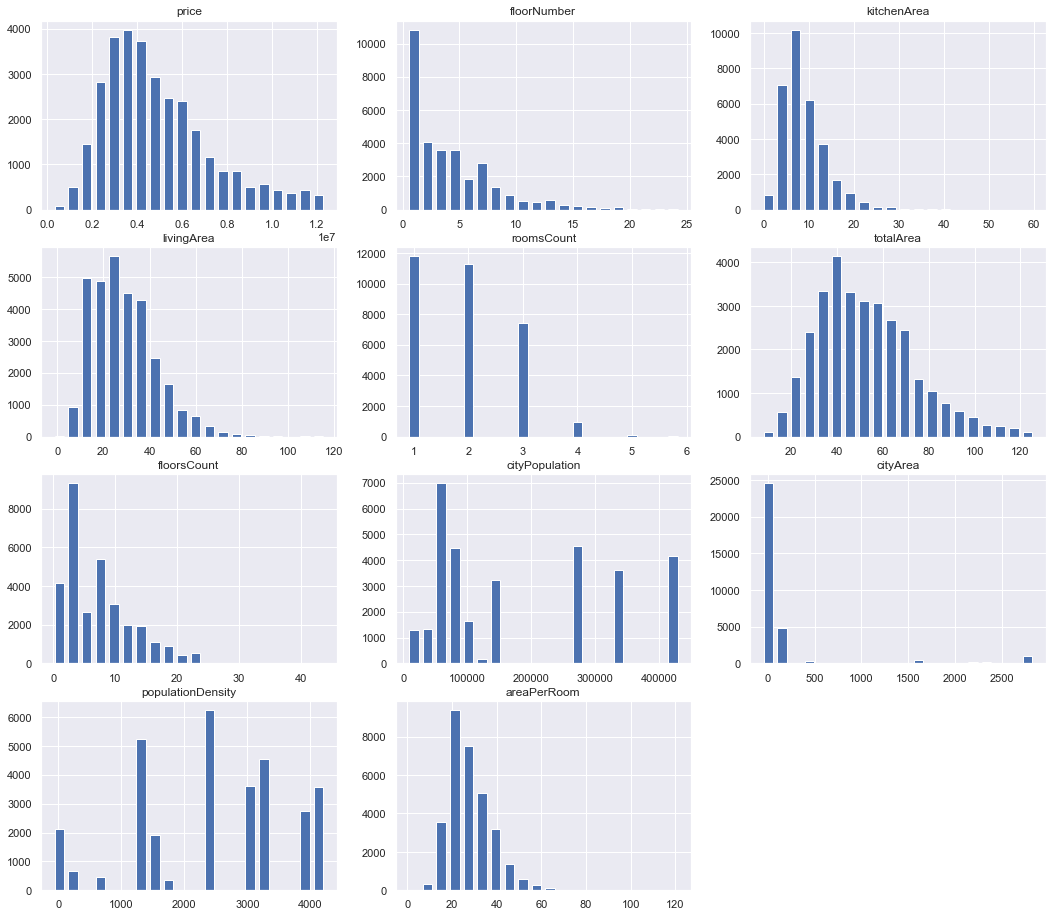

In [93]:
visualize_distributions({
    'price': df.price,
    'floorNumber': df.floorNumber,
    'kitchenArea': df.kitchenArea,
    'livingArea': df.livingArea,
    'roomsCount': df.roomsCount,
    'totalArea': df.totalArea,
    'floorsCount': df.floorsCount,
    'cityPopulation': df.cityPopulation,
    'cityArea': df.cityArea,
    'populationDensity': df.populationDensity,
    'areaPerRoom': df.areaPerRoom,
})

Видим, что числовые признаки необходимо будет нормализовть и логорифмировать для получения нормального распределения.

## Анализ номинативных переменных
Посмотрим на распределение стоймости квартир в зависимости от значения номинативных переменных.

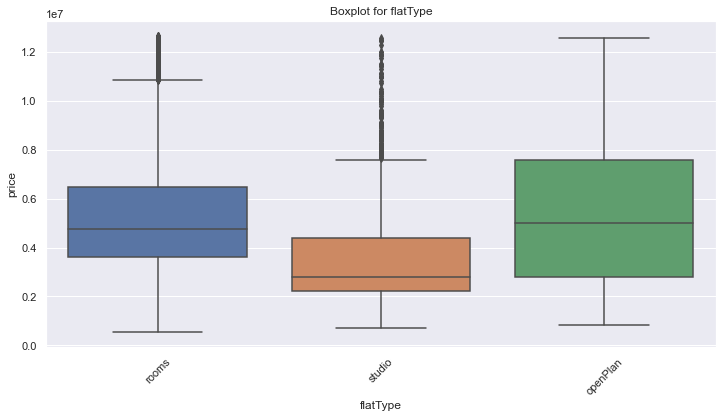

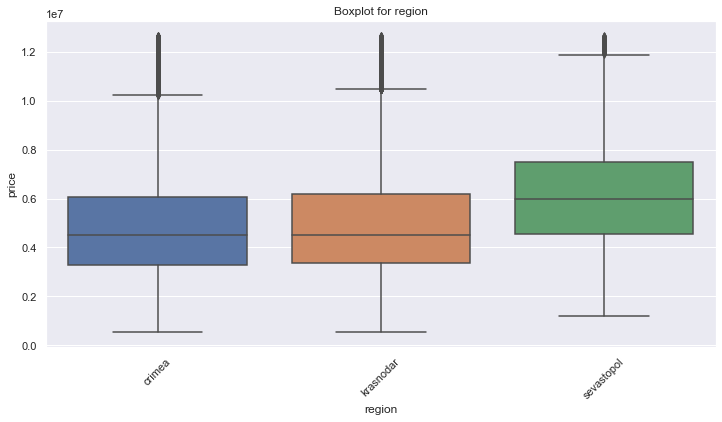

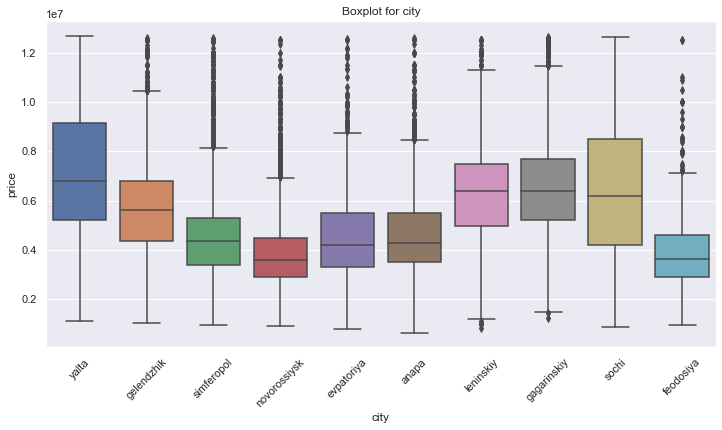

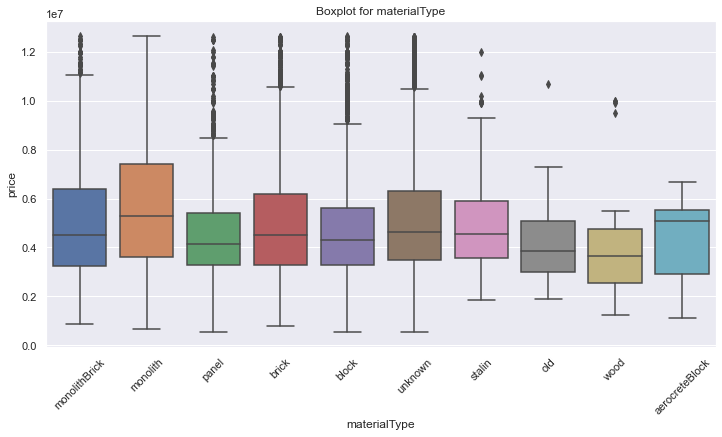

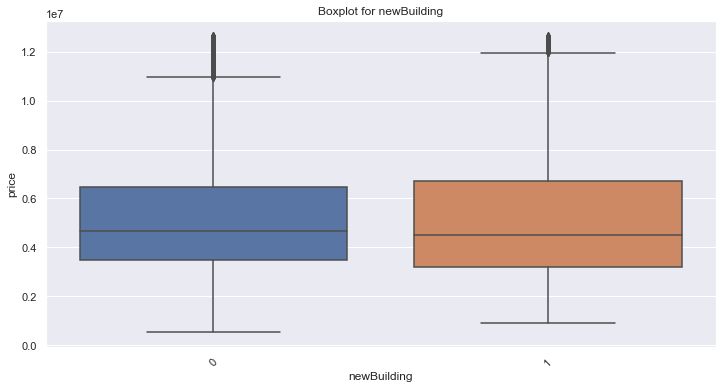

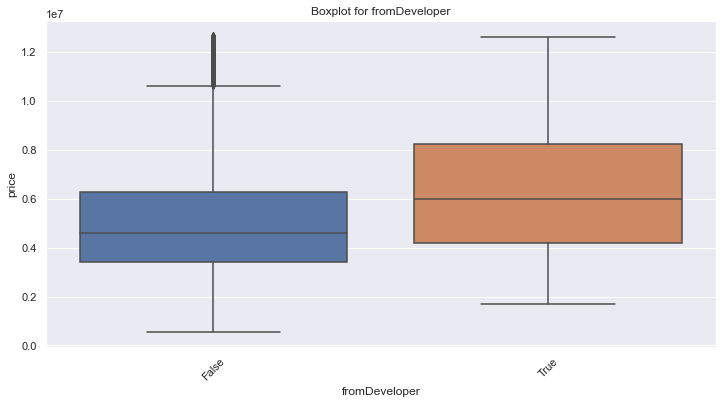

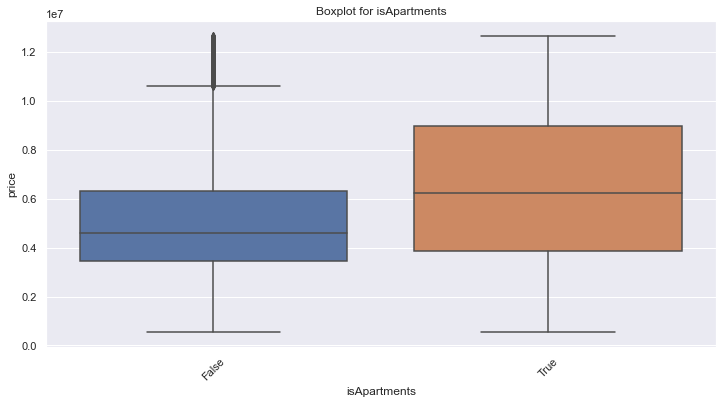

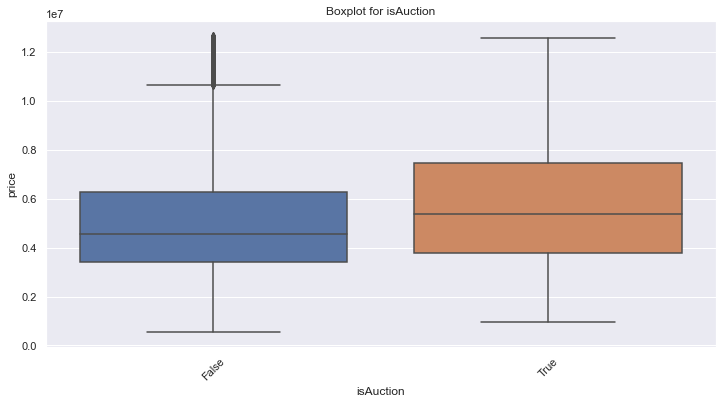

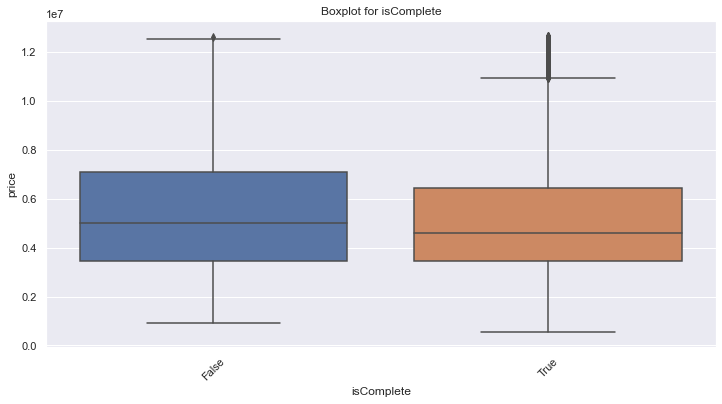

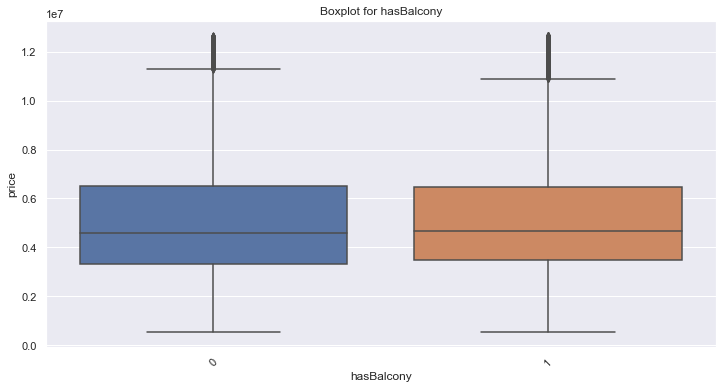

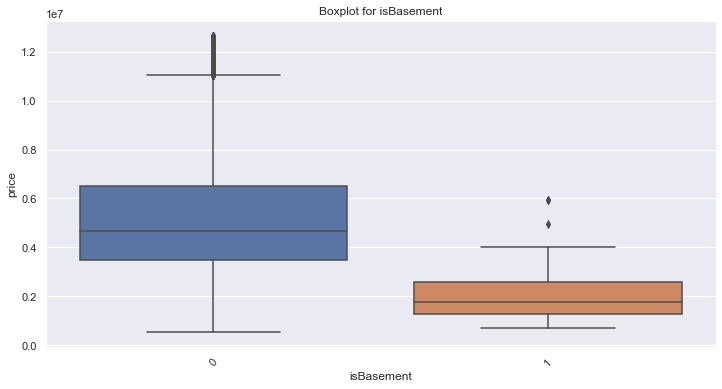

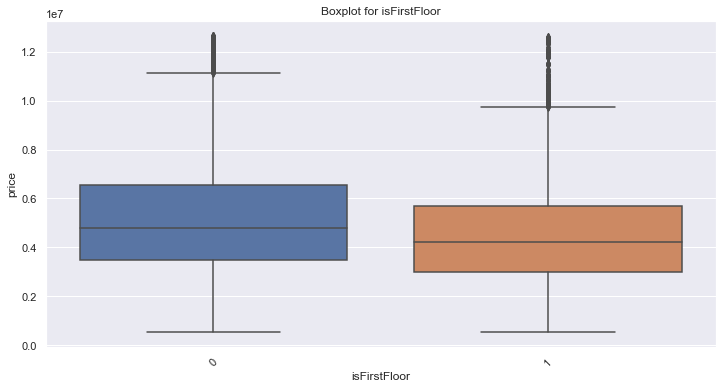

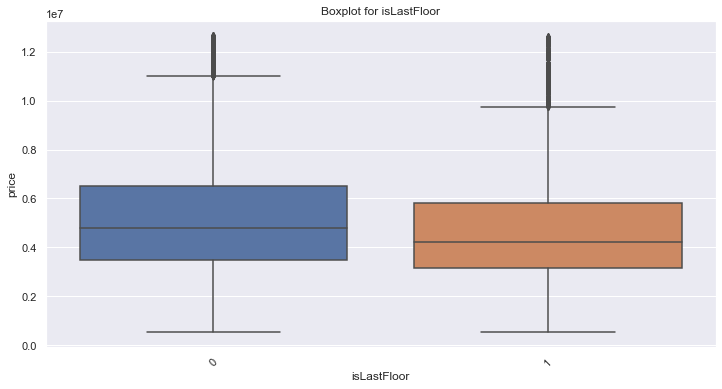

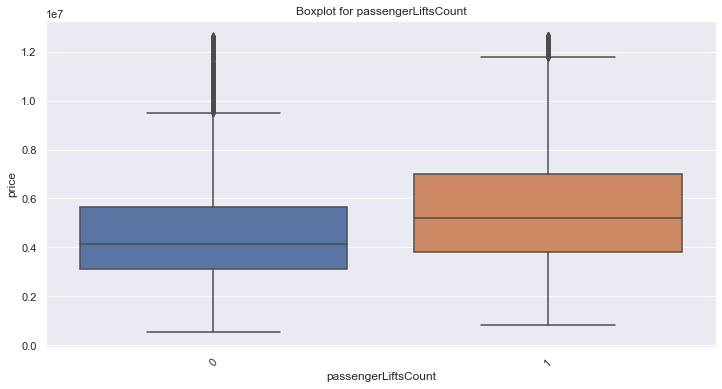

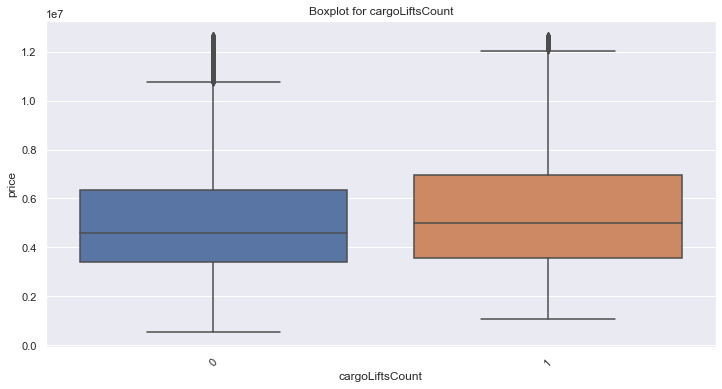

In [94]:
for col in chain(cat_features, bin_features):
    get_boxplot(col)

По графикам похоже, что все параметры, кроме newBuilding и isLastFloor могут влиять на стоимость квартиры.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения стоимости квартир по различным параметрам неразличимы:

In [95]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'price'], 
                        df.loc[df.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [96]:
for col in chain(cat_features, bin_features):
    get_stat_dif(col)

Найдены статистически значимые различия для колонки flatType
Найдены статистически значимые различия для колонки region
Найдены статистически значимые различия для колонки city
Найдены статистически значимые различия для колонки materialType
Найдены статистически значимые различия для колонки fromDeveloper
Найдены статистически значимые различия для колонки isApartments
Найдены статистически значимые различия для колонки isAuction
Найдены статистически значимые различия для колонки isComplete
Найдены статистически значимые различия для колонки hasBalcony
Найдены статистически значимые различия для колонки isBasement
Найдены статистически значимые различия для колонки isFirstFloor
Найдены статистически значимые различия для колонки isLastFloor
Найдены статистически значимые различия для колонки passengerLiftsCount
Найдены статистически значимые различия для колонки cargoLiftsCount


Видим, что только признак newBuilding не является значимым по тесту Стьюдента

# Отбор признаков

## Предобработка датасета

Для начала сделаем label encodong для бинарных признаков и создадим dummy-переменные для категориальных признаков

In [97]:
# label encoding
for column in bin_features:
    df[column] = df[column].astype('category').cat.codes
    
# one-hot encoding
df = pd.get_dummies(df, columns=cat_features, dummy_na=False)

In [98]:
# зададим количество признаков, которое хотим оставить
num_feats = 20

# выделим признаки и целевую переменную в датасете
y = df.price.values
X = df.drop(['price'], axis=1)

## 1. Корреляция Пирсона

Проверим абсолютное значение корреляции Пирсона между числовыми признаками и целевой переменной в нашем датасете. Оставим 20 признаков.

In [99]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # считаем корреляцию для каждого признака
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # заменяем NaN на 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # название признака
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # отобран ли признак? 0 если не отобран, 1 если отобран
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y, num_feats)
print(str(len(cor_feature)), 'selected features:')
for i in cor_feature[::-1]:
    print(i)

20 selected features:
totalArea
livingArea
kitchenArea
roomsCount
city_yalta
passengerLiftsCount
city_novorossiysk
city_sochi
areaPerRoom
flatType_studio
populationDensity
region_sevastopol
city_gagarinskiy
flatType_rooms
materialType_monolith
city_kerch
floorsCount
isFirstFloor
fromDeveloper
isApartments


## 2. Хи-квадрат (Chi-squared score)

Посчитаем метрику хи-квадрат между числовыми признаками и целевой переменной и оставим переменные с максимальным значением метрики

In [100]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features:')
for i in chi_feature[::-1]:
    print(i)

20 selected features:
materialType_monolith
city_yalta
city_tuapsinskiy
city_tuapse
city_sochi
city_simferopolskiy
city_novorossiysk
city_gagarinskiy
city_evpatoriya
city_anapa
city_alushta
region_sevastopol
region_crimea
flatType_studio
flatType_openPlan
cargoLiftsCount
isAuction
isApartments
fromDeveloper
newBuilding


## 3. Метод RFE (Recursive Feature Elimination)

Цель методе RFE состоит в том, чтобы выбрать функции, рекурсивно рассматривая все меньшие и меньшие наборы признаков. Сначала происходит обучение на начальном наборе признаков. Затем наименее важные признаки удаляются из текущего набора. Эта процедура рекурсивно повторяется для сокращенного набора, пока в конечном итоге не будет достигнуто желаемое количество признаков. 

In [101]:
rfe_selector = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features:')
for i in chi_feature[::-1]:
    print(i)

Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30 features.
20 selected features:
materialType_monolith
city_yalta
city_tuapsinskiy
city_tuapse
city_sochi
city_simferopolskiy
city_novorossiysk
city_gagarinskiy
city_evpatoriya
city_anapa
city_alushta
region_sevastopol
region_crimea
flatType_studio
flatType_openPlan
cargoLiftsCount
isAuction
isApartments
fromDeveloper
newBuilding


## 4. Lasso: SelectFromModel

Данный метод реализует l1-регуляризацию

In [102]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features:')
for i in embeded_lr_feature[::-1]:
    print(i)

20 selected features:
materialType_monolith
city_yalta
city_sochi
city_novorossiysk
city_evpatoriya
city_anapa
region_krasnodar
region_crimea
flatType_rooms
populationDensity
isLastFloor
hasBalcony
cargoLiftsCount
passengerLiftsCount
isComplete
totalArea
isAuction
isApartments
fromDeveloper
newBuilding


## 5. Объединение результатов различных методов

Сведем результаты различных методов отбора признаков в единый датасет и отсортируем по количеству методов, которые выделили признак как значимый.

In [103]:
feature_selection_df = pd.DataFrame({
    'Feature':X.columns,
    'Pearson':cor_support,
    'Chi-2':chi_support,
    'RFE':rfe_support,
    'Logistics':embeded_lr_support,
})
# считаем количество раз, которе признак был отобран
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# сортируем и отображаем датасет
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(30)

,Feature,Pearson,Chi-2,RFE,Logistics,Total
1,materialType_monolith,True,True,True,True,4
2,totalArea,True,False,True,True,3
3,region_sevastopol,True,True,True,False,3
4,region_crimea,False,True,True,True,3
5,populationDensity,True,False,True,True,3
6,passengerLiftsCount,True,False,True,True,3
7,isApartments,True,True,False,True,3
8,fromDeveloper,True,True,False,True,3
9,flatType_studio,True,True,True,False,3
10,flatType_rooms,True,False,True,True,3


Оставим признаки, отобранные хотя бы двумя методами.

In [104]:
df_model = df[[
    'materialType_monolith',
    'totalArea',
    'roomsCount',
    'region_sevastopol',
    'region_crimea',
    'populationDensity',
    'passengerLiftsCount',
    'isApartments',
    'fromDeveloper',
    'flatType_studio',
    'flatType_rooms',
    'city_yalta',
    'city_sochi',
    'city_novorossiysk',
    'city_anapa',
    'region_krasnodar',
    'newBuilding',
    'livingArea',
    'isFirstFloor',
    'isComplete',
    'isAuction',
    'hasBalcony',
    'city_gagarinskiy',
    'city_evpatoriya',
    'cargoLiftsCount',
    'areaPerRoom',
    'price',
]]

# Результаты EDA

В результате EDA мы проделали следующую работу:
* Ознакомились с данными.
* Избавились от пропусков.
* Избавились от выбросов в переменных price и totalArea.
* Сгенерировали новые признаки.
* Провели корреляционный анализ числовых признаков.
* Посмотрели на распределение числовых признаков, в результате решили в дальнейшем нормализовать и логорифмировать числовые признаки.
* Провели анализ номинативных переменных, в результате увидили слаболе влияние параметра newBuilding на целевую переменную.
* Провели отбор признаков различными методами.

Сохраним датасет для дальнейшего использования при обучении модели.

In [105]:
df_model.to_csv('cian_model.csv', index=False)